In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import re
import numpy as np
import umap.umap_ as umap
import joblib
import pickle
from sklearn.preprocessing import RobustScaler, FunctionTransformer, StandardScaler, MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sentence_transformers import SentenceTransformer

In [ ]:
df_merged = pd.read_csv('data/processed/Ingredients_And_Nutrition_Merged_New.csv')

In [28]:
nutri_cols = ["calories", "protein", "fat", "carbohydrate"]
diet_prefs = [
    "halal", "is_lactose_free", "low_carb", "weight_loss", 
    "high_protein", "gluten_free", "dairy_free",
    "is_spicy", "is_not_fried"
]

allergen_cols = [
    "has_dairy","has_egg","has_fish","has_shellfish","has_soy","has_sesame",
    "has_wheat","has_peanut","has_treenut"
]
df_merged['text_feature'] =(
    df_merged['Title'].astype(str) + " " +
    df_merged['Ingredients_Text'].astype(str) + " "
)

In [29]:
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import PCA

# Weighting Helper
def apply_weight(X, weight=1.0):
    return X * weight

# Pipeline
nutri_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 3.0}))
])

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,3),
    min_df=3,
    max_df=0.8,
    stop_words='english',
    sublinear_tf=True)),
    ('svd', TruncatedSVD(n_components=50, random_state=42)),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 1.0}))
])

categorical_pipe_1_0 = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 0.5}))
])

# 2. Preprocessor tetap sama
preprocessor = ColumnTransformer(
    transformers=[
        ('nutri',    nutri_pipe, nutri_cols),
        ('text',     text_pipe, 'text_feature'),
        ('allergen', categorical_pipe_1_0, allergen_cols),
        ('diet',     categorical_pipe_1_0, diet_prefs)
    ],
    remainder='drop'
)

# 3. Buat Final Pipeline dengan Normalizer
final_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_food_a = final_pipeline.fit_transform(df_merged)

Training Agglomerative (Ward) for k=2...
   Silhouette Score: 0.4790
Training Agglomerative (Ward) for k=3...
   Silhouette Score: 0.4526
Training Agglomerative (Ward) for k=4...
   Silhouette Score: 0.4170
Training Agglomerative (Ward) for k=5...
   Silhouette Score: 0.4198
Training Agglomerative (Ward) for k=6...
   Silhouette Score: 0.2214
Training Agglomerative (Ward) for k=7...
   Silhouette Score: 0.2449
Training Agglomerative (Ward) for k=8...
   Silhouette Score: 0.2491
Training Agglomerative (Ward) for k=9...
   Silhouette Score: 0.2500


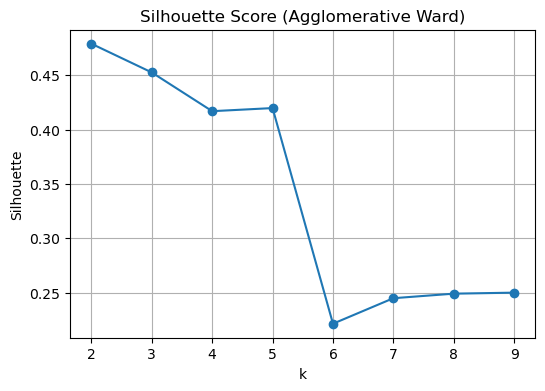

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sil_scores = []
K_values = range(2, 10, 1)  # k = 2 sampai 9

for k in K_values:
    print(f"Training Agglomerative (Ward) for k={k}...")

    agg = AgglomerativeClustering(
        n_clusters=k,
        linkage='ward'  # WAJIB euclidean
    )
    
    labels = agg.fit_predict(X_food_a)

    # Silhouette (pakai sample_size kalau data besar)
    if len(X_food_a) > 10000:
        sil = silhouette_score(
            X_food_a,
            labels,
            sample_size=10000,
            random_state=42
        )
    else:
        sil = silhouette_score(X_food_a, labels)

    sil_scores.append(sil)
    print(f"   Silhouette Score: {sil:.4f}")

# =====================
# Plot Silhouette
# =====================
plt.figure(figsize=(6,4))
plt.plot(K_values, sil_scores, '-o')
plt.title("Silhouette Score (Agglomerative Ward)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()


--- Evaluasi Agglomerative Clustering ---
Silhouette Score (↑): 0.4170
Davies-Bouldin Index (↓): 1.0961
Calinski-Harabasz Index (↑): 1990.9707



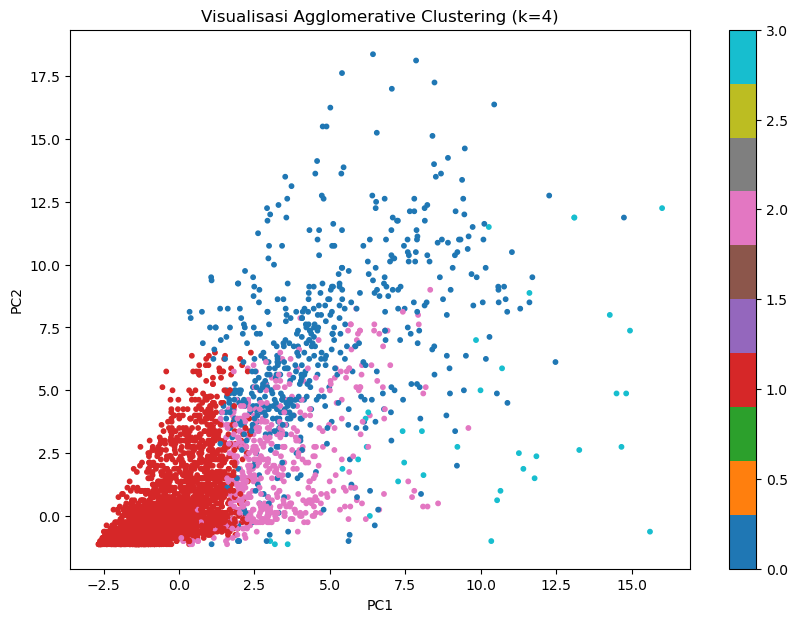

In [31]:
from sklearn.cluster import AgglomerativeClustering

def evaluate_clustering(X, labels, model_name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    
    print(f"--- Evaluasi {model_name} ---")
    print(f"Silhouette Score (↑): {sil:.4f}")
    print(f"Davies-Bouldin Index (↓): {db:.4f}")
    print(f"Calinski-Harabasz Index (↑): {ch:.4f}\n")
    return sil, db, ch


# 1. Jalankan Agglomerative
k = 4
agglo = AgglomerativeClustering(n_clusters=k, linkage='ward') # 'ward' paling umum untuk meminimalkan varians
agglo_labels = agglo.fit_predict(X_food_a)

# 2. Evaluasi menggunakan fungsi yang kita buat tadi
agglo_metrics = evaluate_clustering(X_food_a, agglo_labels, "Agglomerative Clustering")

# 3. Visualisasi
plt.figure(figsize=(10, 7))
plt.scatter(X_food_a[:, 0], X_food_a[:, 1], c=agglo_labels, cmap='tab10', s=10)
plt.colorbar()
plt.title(f"Visualisasi Agglomerative Clustering (k={k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [32]:
# 4. Print Persebaran Data
cluster_counts = pd.Series(agglo_labels).value_counts().sort_index()
total_data = len(agglo_labels)

print("\n" + "="*30)
print("PERSEBARAN DATA CLUSTER")
print("="*30)
for cluster_id, count in cluster_counts.items():
    percentage = (count / total_data) * 100
    print(f"Cluster {cluster_id}: {count} resep ({percentage:.2f}%)")
print("="*30)
print(f"Total: {total_data} resep")


PERSEBARAN DATA CLUSTER
Cluster 0: 548 resep (13.14%)
Cluster 1: 3055 resep (73.23%)
Cluster 2: 532 resep (12.75%)
Cluster 3: 37 resep (0.89%)
Total: 4172 resep


In [33]:
df_merged['Agglo_Cluster'] = agglo_labels

In [34]:
pd.set_option('display.max_columns', None)

In [35]:
# 1. Tentukan kolom yang ingin di-profile
profile_cols = ["calories", "protein", "fat", "carbohydrate", "cooking_time"]

# 2. Buat tabel profiling dengan agregasi Lengkap
cluster_profiling = df_merged.groupby('Agglo_Cluster')[profile_cols].agg(['mean', 'min', 'max', 'std']).round(2)

# 3. Tambahkan jumlah data per cluster agar terlihat bobotnya
cluster_profiling['count'] = df_merged['Agglo_Cluster'].value_counts().sort_index()

# Menampilkan tabelt
print("=== Tabel Profiling Cluster Nutrisi ===")
display(cluster_profiling)

=== Tabel Profiling Cluster Nutrisi ===


calories                        protein                     \
                  mean    min     max     std    mean  min    max    std   
Agglo_Cluster                                                              
0              1002.83  406.0  2341.0  336.54   63.04  0.0  156.0  27.81   
1               287.71    0.0   686.0  150.24   10.04  0.0   61.0  11.17   
2               800.48  369.0  1648.0  207.49   26.82  0.0   81.0  16.98   
3              1696.68  765.0  2511.0  489.93   39.11  0.0  107.0  30.39   

                 fat                    carbohydrate                         \
                mean  min    max    std         mean     min     max    std   
Agglo_Cluster                                                                 
0              70.28  8.0  158.0  30.13        29.54    0.00  142.75  23.69   
1              15.08  0.0   48.0  11.15        27.95    0.00   96.75  20.59   
2              42.12  0.0  103.0  18.44        78.54   16.00  189.25  31.81   
3              52.24  0.0  132.0  39.49       267.51  177.75  569.75  86.12   

              cooking_time                   count  
                      mean min   max     std        
Agglo_Cluster                                       
0                   180.55   1  2880  356.45   548  
1                    88.54   1  4320  199.97  3055  
2                   101.84   1  1440  177.19   532  
3                   148.22   1  2160  359.28    37

In [ ]:
df_model_a = df_merged[['recipe_id', 'Title', 'text_feature', 'cooking_time'] + nutri_cols + allergen_cols + diet_prefs ].copy()
df_model_a['cluster'] = agglo_labels

# Menyiapkan dictionary untuk di-save
model_a_data = {
    'metadata': df_model_a,      
    'matrix_a': X_food_a.astype('float32'),        
    'pipeline_a': final_pipeline 
}

# Simpan ke file pickle
with open('models/nutri_engine_agglo.pkl', 'wb') as f:
    pickle.dump(model_a_data, f)

print("Success !!")


Success !!
